Configurar la API de Kaggle en Google Colab

In [ ]:
# Instalar la librería de Kaggle
!pip install -q kaggle

# Subir el archivo kaggle.json (ejecuta esto y sube el archivo manualmente)
from google.colab import files
files.upload()

# Mover el archivo a la ubicación correcta
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (3).json


Descargar el dataset

In [ ]:
# Descargar el dataset
!kaggle datasets download -d theblackmamba31/landscape-image-colorization

# Descomprimir el archivo
!unzip landscape-image-colorization.zip -d landscape-data

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: landscape-data/landscape Images/gray/2914.jpg  
  inflating: landscape-data/landscape Images/gray/2915.jpg  
  inflating: landscape-data/landscape Images/gray/2916.jpg  
  inflating: landscape-data/landscape Images/gray/2917.jpg  
  inflating: landscape-data/landscape Images/gray/2918.jpg  
  inflating: landscape-data/landscape Images/gray/2919.jpg  
  inflating: landscape-data/landscape Images/gray/292.jpg  
  inflating: landscape-data/landscape Images/gray/2920.jpg  
  inflating: landscape-data/landscape Images/gray/2921.jpg  
  inflating: landscape-data/landscape Images/gray/2922.jpg  
  inflating: landscape-data/landscape Images/gray/2923.jpg  
  inflating: landscape-data/landscape Images/gray/2924.jpg  
  inflating: landscape-data/landscape Images/gray/2925.jpg  
  inflating: landscape-data/landscape Images/gray/2926.jpg  
  inflating: landscape-data/landscape Images/gray/2927.jpg  
  inflating: landsc

verificamos en contenido de las imagenes

In [ ]:
import os

# Ruta del dataset
data_dir = '/content/landscape-data'

# Listar contenido de 'landscape Images'
landscape_dir = os.path.join(data_dir, 'landscape Images')
print("Contenido de 'landscape Images':", os.listdir(landscape_dir))

Contenido de 'landscape Images': ['color', 'gray']


Explorar el dataset y visualizar imágenes

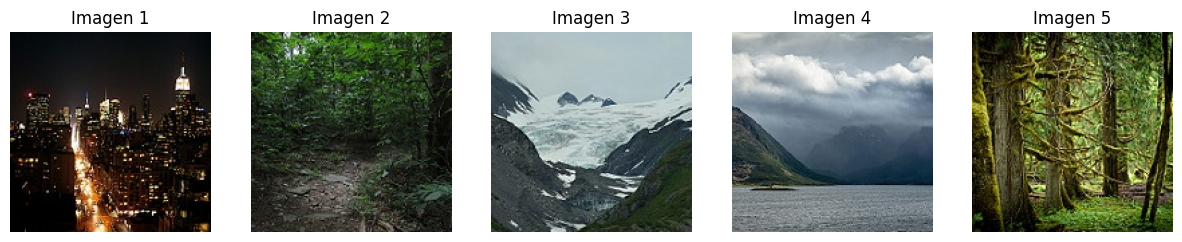

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import random

# Ruta de imágenes
image_dir = os.path.join(data_dir, 'landscape Images/color')
images = os.listdir(image_dir)

# Mostrar 5 imágenes aleatorias
plt.figure(figsize=(15, 10))
for i in range(5):
    img_path = os.path.join(image_dir, random.choice(images))
    try:
        img = Image.open(img_path)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(f"Imagen {i+1}")
        plt.axis('off')
    except Exception as e:
        print(f"Error al cargar {img_path}: {e}")
plt.show()

 Normalización de imágenes
Normalizaremos los valores de píxeles de [0, 255] a [-1, 1] (estándar en GANs/generación) o [0, 1]

In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import matplotlib.pyplot as plt

In [ ]:

# Transformaciones para imágenes RGB
transform = transforms.Compose([
    transforms.Resize((256, 256)),          # Redimensionar
    transforms.ToTensor(),                 # Convertir a tensor [0, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Escalar a [-1, 1]
])

Dataset Customizado

In [ ]:
def extract_palette(image_path, n_colors=5):
    from sklearn.cluster import KMeans
    import numpy as np
    from collections import Counter

    image = Image.open(image_path).convert('RGB')
    img_array = np.array(image)
    pixels = img_array.reshape(-1, 3)

    kmeans = KMeans(n_clusters=n_colors, random_state=42)
    kmeans.fit(pixels)

    counts = Counter(kmeans.labels_)
    total_pixels = sum(counts.values())
    palette = []

    for i in range(n_colors):
        color = kmeans.cluster_centers_[i].astype(float) / 255.0  # Normalizado a [0,1]
        frequency = counts[i] / total_pixels
        palette.append((color, frequency))

    return palette

In [ ]:
class ColorPaletteDataset(Dataset):
    def __init__(self, image_dir, transform=None, n_colors=5):
        self.image_dir = image_dir
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)
                          if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        self.transform = transform
        self.n_colors = n_colors  # Número de colores dominantes a extraer

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        # Extraer paleta de colores (función que definiremos después)
        palette = extract_palette(img_path, self.n_colors)
        palette_tensor = torch.FloatTensor([color for color, _ in palette])  # Shape: [n_colors, 3]

        if self.transform:
            image = self.transform(image)

        return image, palette_tensor  # ¡Ahora devuelve ambos!

In [ ]:
# Prueba con una imagen
test_dataset = ColorPaletteDataset(
    image_dir='/content/landscape-data/landscape Images/color',
    transform=transform,
    n_colors=5
)

image, palette = test_dataset[0]
print("Shape imagen:", image.shape)  # Debería ser [3, 256, 256]
print("Shape paleta:", palette.shape)  # Debería ser [5, 3]
print("Valores paleta (deben estar entre 0-1):", palette.min().item(), palette.max().item())

Shape imagen: torch.Size([3, 256, 256])
Shape paleta: torch.Size([5, 3])
Valores paleta (deben estar entre 0-1): 0.09505587816238403 0.9553936123847961


Cargar y visualizar imágenes normalizadas

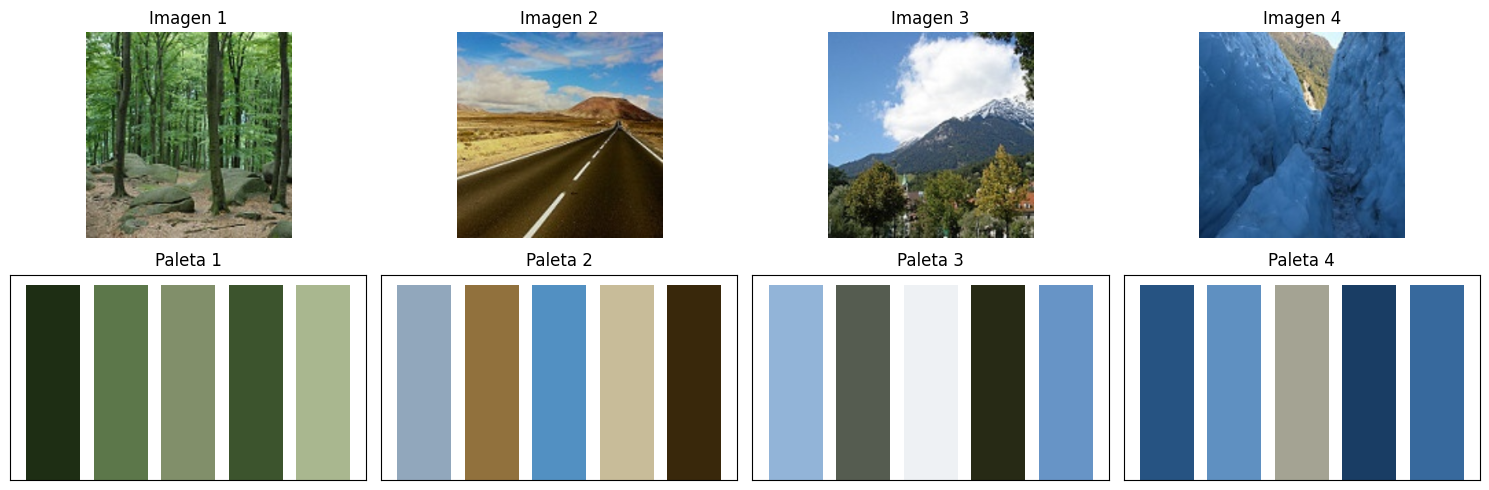

In [ ]:
# 1. Crear Dataset con paletas (USANDO LA NUEVA CLASE)
color_dir = '/content/landscape-data/landscape Images/color'
dataset = ColorPaletteDataset(color_dir, transform=transform, n_colors=5)  # <- Cambiado a ColorPaletteDataset

# 2. Crear DataLoader (igual pero ahora manejará tuplas)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# 3. Función para desnormalizar imágenes (se mantiene igual)
def imshow(img):
    img = img.numpy()
    img = img.transpose(1, 2, 0)            # Cambiar de [C, H, W] a [H, W, C]
    img = img * 0.5 + 0.5                   # Desnormalizar a [0, 1]
    plt.imshow(img)
    plt.axis('off')

# 4. Mostrar batch CON PALETAS (versión mejorada)
def show_batch(images, palettes):
    plt.figure(figsize=(15, 5))
    for i in range(min(4, len(images))):     # Mostrar máximo 4 imágenes
        # Mostrar imagen
        plt.subplot(2, 4, i+1)
        imshow(images[i])
        plt.title(f"Imagen {i+1}")

        # Mostrar paleta
        plt.subplot(2, 4, i+5)
        palette = palettes[i].cpu().numpy()
        for j, color in enumerate(palette):
            plt.bar(j, 1, color=np.clip(color, 0, 1))  # Asegurar rango [0,1]
        plt.xticks([])
        plt.yticks([])
        plt.title(f"Paleta {i+1}")
    plt.tight_layout()
    plt.show()

# 5. Obtener y mostrar un batch
images, palettes = next(iter(dataloader))    # Ahora desempaquetamos dos valores
show_batch(images, palettes)

In [ ]:
# Obtener un batch de ejemplo
images, palettes = next(iter(dataloader))  # Desempaquetamos ambos elementos

# Verificar rango de las IMÁGENES (deben estar en [-1, 1] por la normalización)
print("Rango de imágenes (debería ser ~[-1, 1]):")
print(f"• Mínimo: {images.min().item():.4f}")
print(f"• Máximo: {images.max().item():.4f}")

# Verificar rango de las PALETAS (deben estar en [0, 1])
print("\nRango de paletas (debería ser ~[0, 1]):")
print(f"• Mínimo: {palettes.min().item():.4f}")
print(f"• Máximo: {palettes.max().item():.4f}")

Rango de imágenes (debería ser ~[-1, 1]):
• Mínimo: -1.0000
• Máximo: 1.0000

Rango de paletas (debería ser ~[0, 1]):
• Mínimo: 0.0287
• Máximo: 0.9150


División del Dataset (entrenamiento (80%), validación (10%))

In [ ]:
from torch.utils.data import random_split
import torch

# 1. Configuración inicial
torch.manual_seed(42)  # Para reproducibilidad
test_val_ratio = 0.1  # 10% para validación, 10% para test

# 2. División más precisa
total_size = len(dataset)
val_test_size = int(total_size * test_val_ratio)
train_size = total_size - 2 * val_test_size  # 80% restante

# 3. División con mensajes detallados
train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_test_size, val_test_size],
    generator=torch.Generator().manual_seed(42)  # Extra de reproducibilidad
)

# 4. Verificación de tamaños
print(f"⚡ División del Dataset (Total: {total_size} imágenes)")
print(f"• Entrenamiento: {len(train_dataset)} imágenes ({len(train_dataset)/total_size:.0%})")
print(f"• Validación: {len(val_dataset)} imágenes ({len(val_dataset)/total_size:.0%})")
print(f"• Prueba: {len(test_dataset)} imágenes ({len(test_dataset)/total_size:.0%})")

# 5. Verificación de contenido (opcional pero útil)
print("\n🔍 Verificación rápida de estructura:")
sample, _ = train_dataset[0]  # Usamos _ para ignorar las paletas en esta verificación
print(f"Tipo de muestra: {type(sample)}")
print(f"Shape de imagen: {sample.shape}")  # Debería ser [3, 256, 256]

⚡ División del Dataset (Total: 7129 imágenes)
• Entrenamiento: 5705 imágenes (80%)
• Validación: 712 imágenes (10%)
• Prueba: 712 imágenes (10%)

🔍 Verificación rápida de estructura:
Tipo de muestra: <class 'torch.Tensor'>
Shape de imagen: torch.Size([3, 256, 256])


Crear DataLoaders para cada grupo

In [ ]:
# Configuración avanzada de DataLoaders
batch_size = 16  # Puedes reducir a 16 si hay problemas de memoria en GPU
num_workers = 2  # Número de subprocesos para carga de datos (2-4 es óptimo en Colab)

# Configurar pin_memory para transferencia más rápida a GPU
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,  # Acelera la transferencia CPU→GPU
    drop_last=True    # Descarta el último batch incompleto
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,    # No mezclar para evaluación consistente
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

# Verificación de los DataLoaders
print(f"🚀 DataLoaders creados (Batch size: {batch_size})")
print(f"• Train batches: {len(train_loader)}")
print(f"• Val batches: {len(val_loader)}")
print(f"• Test batches: {len(test_loader)}")

# Verificación de la estructura del primer batch (opcional pero recomendado)
sample_batch = next(iter(train_loader))
images, palettes = sample_batch
print(f"\n🔍 Verificación de estructura:")
print(f"- Tipo de batch: {type(sample_batch)} (debe ser tuple)")
print(f"- Imágenes shape: {images.shape} (debe ser [batch_size, 3, 256, 256])")
print(f"- Paletas shape: {palettes.shape} (debe ser [batch_size, 5, 3])")

🚀 DataLoaders creados (Batch size: 16)
• Train batches: 356
• Val batches: 45
• Test batches: 45

🔍 Verificación de estructura:
- Tipo de batch: <class 'list'> (debe ser tuple)
- Imágenes shape: torch.Size([16, 3, 256, 256]) (debe ser [batch_size, 3, 256, 256])
- Paletas shape: torch.Size([16, 5, 3]) (debe ser [batch_size, 5, 3])


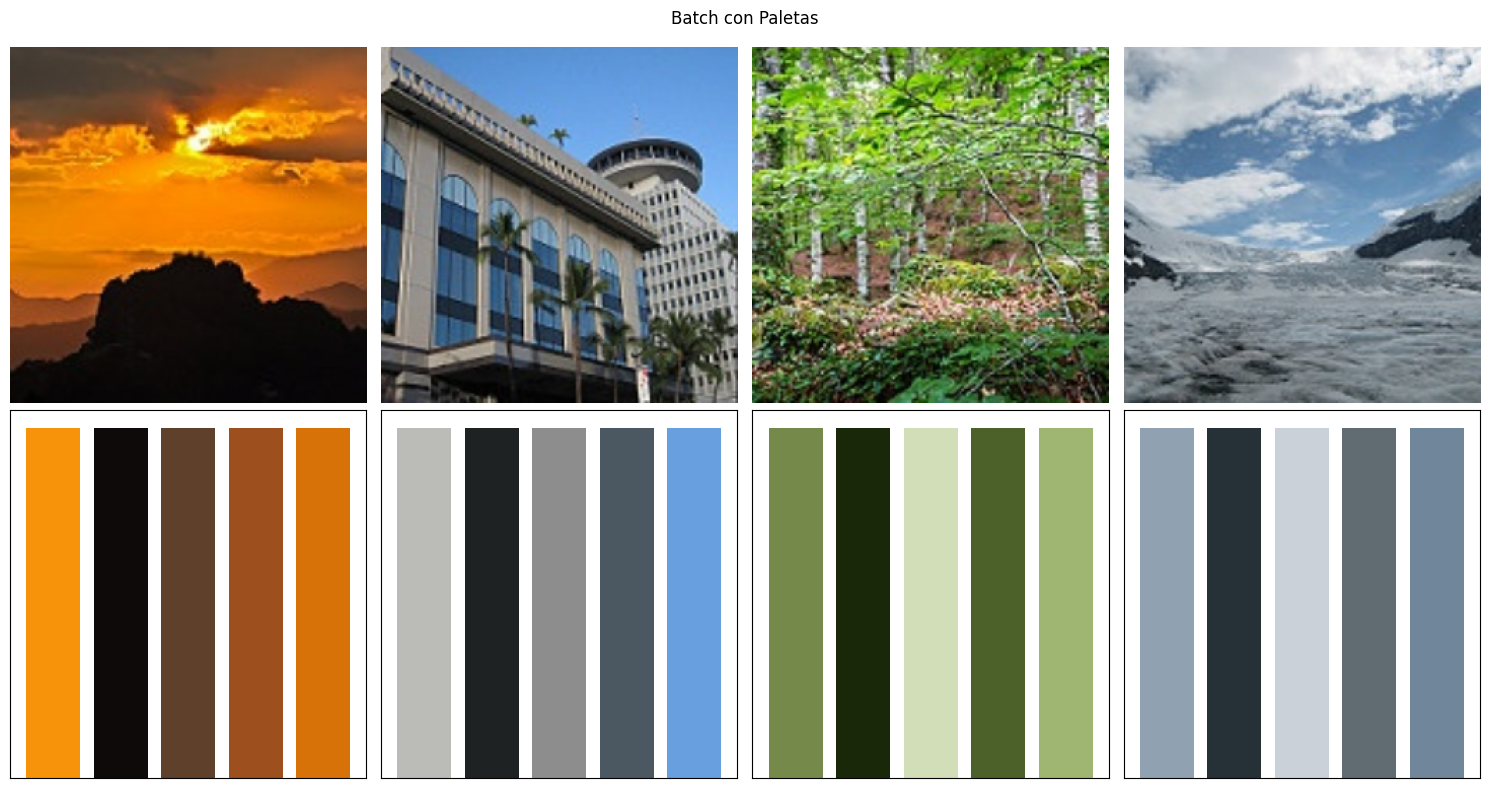

In [ ]:
def show_batch_with_palettes(loader, title):
    images, palettes = next(iter(loader))

    plt.figure(figsize=(15, 8))
    for i in range(min(4, len(images))):
        # Mostrar imagen
        plt.subplot(2, 4, i+1)
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = img * 0.5 + 0.5 if img.min() < 0 else img
        plt.imshow(img)
        plt.axis('off')

        # Mostrar paleta
        plt.subplot(2, 4, i+5)
        palette = palettes[i].cpu().numpy()
        for j, color in enumerate(palette):
            plt.bar(j, 1, color=np.clip(color, 0, 1))
        plt.xticks([])
        plt.yticks([])

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Usar así:
show_batch_with_palettes(train_loader, "Batch con Paletas")

In [ ]:
import torch
torch.cuda.empty_cache()

Verificar una muestra de cada grupo

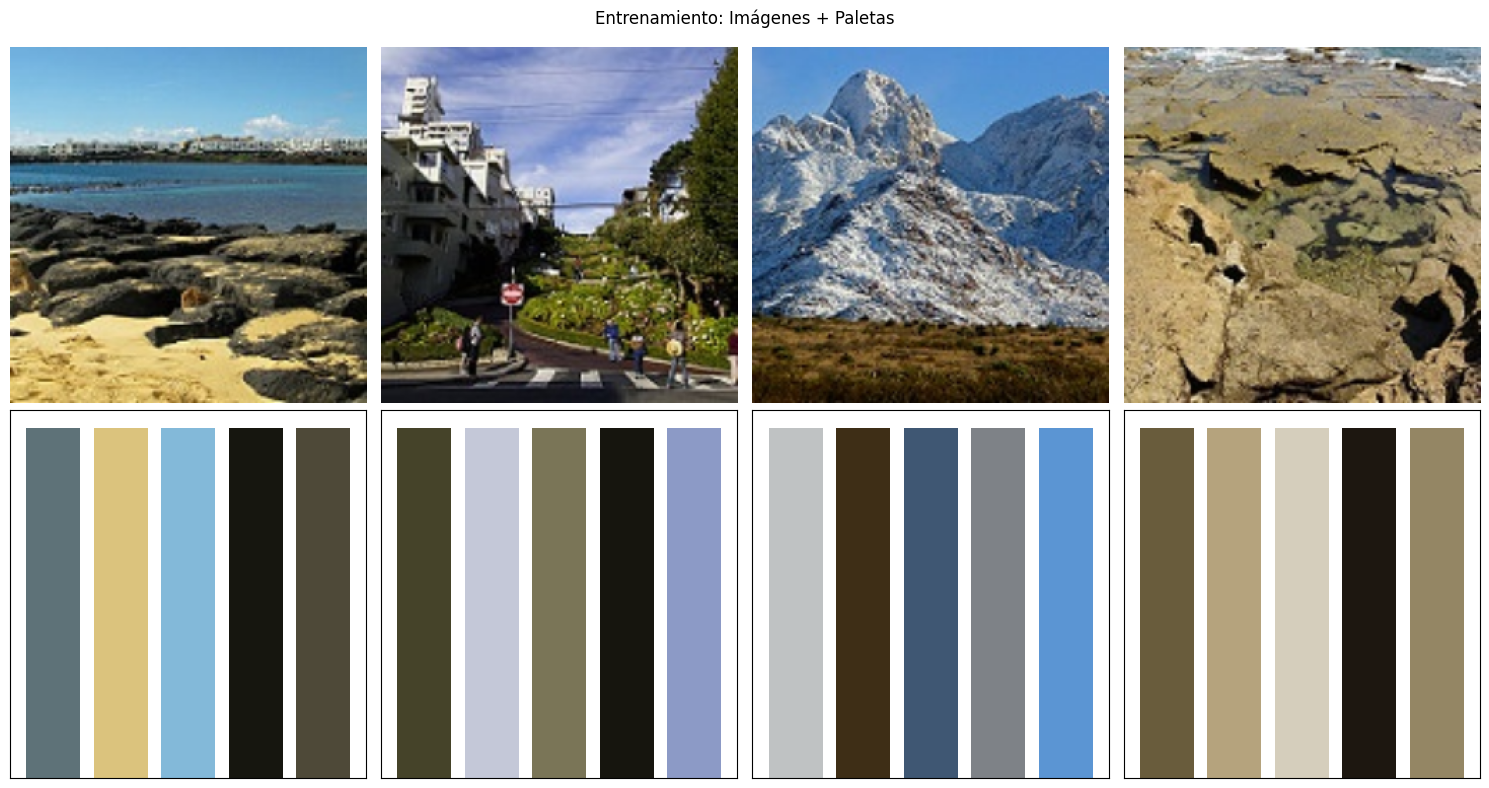

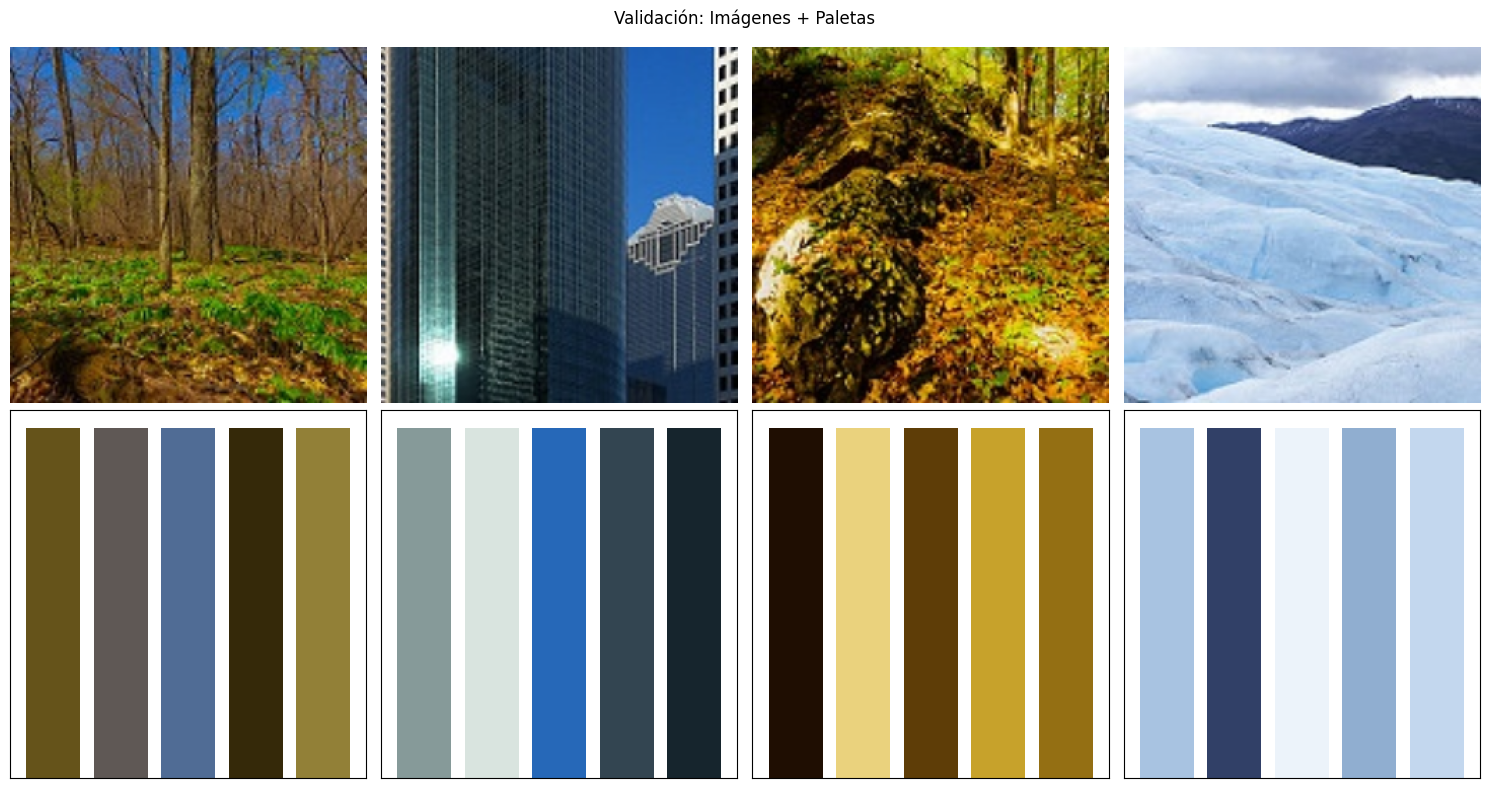

In [ ]:
def show_batch_with_palettes(loader, title):
    images, palettes = next(iter(loader))  # Desempaquetamos ambos

    plt.figure(figsize=(15, 8))
    for i in range(min(4, len(images))):  # Mostrar máximo 4 ejemplos
        # Imagen
        plt.subplot(2, 4, i+1)
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = img * 0.5 + 0.5  # Desnormalizar si está en [-1, 1]
        plt.imshow(img)
        plt.axis('off')

        # Paleta correspondiente
        plt.subplot(2, 4, i+5)
        palette = palettes[i].cpu().numpy()
        for j, color in enumerate(palette):
            plt.bar(j, 1, color=np.clip(color, 0, 1))
        plt.xticks([])
        plt.yticks([])

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Uso:
show_batch_with_palettes(train_loader, "Entrenamiento: Imágenes + Paletas")
show_batch_with_palettes(val_loader, "Validación: Imágenes + Paletas")

In [ ]:
# División aleatoria simple (80/10/10)
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

# Arquitectura del Modelo (CNN + Regresión):
 Crearemos una red neuronal convolucional (CNN) que tome una imagen y prediga una paleta de colores (ej: 5 colores RGB).

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ColorPaletteModel(nn.Module):
    def __init__(self, n_colors=5):
        super(ColorPaletteModel, self).__init__()
        # Capas convolucionales (encoder)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # Reducción de tamaño
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)

        # Capas fully connected (regresión)
        self.fc1 = nn.Linear(128 * 64 * 64, 512)  # Ajustar según tamaño de entrada
        self.fc2 = nn.Linear(512, n_colors * 3)   # Salida: n_colors * 3 (RGB)

        # BatchNorm (¡CORRECCIÓN AQUÍ!)
        self.bn1 = nn.BatchNorm2d(32)  # Para conv1 (canales de salida: 32)
        self.bn2 = nn.BatchNorm2d(64)  # Para conv2 (canales de salida: 64)
        self.bn3 = nn.BatchNorm2d(128) # Para conv3 (canales de salida: 128)

        self.n_colors = n_colors

    def forward(self, x):
        # Forward pass convolucional (¡CON BatchNorm!)
        x = F.relu(self.bn1(self.conv1(x)))  # Conv1 -> BN1 -> ReLU
        x = F.relu(self.bn2(self.conv2(x)))  # Conv2 -> BN2 -> ReLU
        x = F.relu(self.bn3(self.conv3(x)))  # Conv3 -> BN3 -> ReLU

        # Aplanar para fully connected
        x = x.view(x.size(0), -1)

        # Forward pass fully connected
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # Reformatear a (batch_size, n_colors, 3)
        x = x.view(-1, self.n_colors, 3)
        return torch.sigmoid(x)  # Añade sigmoid para normalizar a [0, 1]
        return x.view(-1, self.n_colors, 3)


In [ ]:
def plot_palettes(real, predicted, n_colors=5):
    # Normalizar predicciones a [0, 1] (si son floats)
    predicted_normalized = torch.clamp(predicted, 0, 1)  # Fuerza valores entre 0 y 1

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].imshow([real.cpu().numpy()], aspect='auto')
    ax[0].set_title("Paleta Real")
    ax[1].imshow([predicted_normalized.detach().cpu().numpy()], aspect='auto')
    ax[1].set_title("Paleta Predicha (Normalizada)")
    plt.show()

**Función de Pérdida y Optimizador**
Usaremos MSE Loss (error cuadrático medio) para comparar paletas predichas vs reales, y Adam como optimizador.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# 1. Inicializar modelo (usando tu arquitectura original o la versión corregida)
model = ColorPaletteModel(n_colors=5)  # Asegúrate de que input_height/width sean correctos
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 2. Función de pérdida (MSE para comparar paletas RGB)
criterion = nn.MSELoss()  # Error cuadrático medio entre predichos y reales

# 3. Optimizador (Adam con learning rate estándar)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # lr puede ajustarse

# --- Ejemplo de uso en un paso de entrenamiento ---
def train_step(batch_images, batch_palettes, model, criterion, optimizer):
    """
    batch_images: Tensor de shape [batch_size, 3, height, width] (imágenes normalizadas)
    batch_palettes: Tensor de shape [batch_size, n_colors, 3] (colores RGB reales)
    """
    model.train()  # Modo entrenamiento
    optimizer.zero_grad()  # Resetear gradientes

    # Forward pass
    predicted_palettes = model(batch_images.to(device))  # Predicción: [batch_size, n_colors, 3]

    # Calcular pérdida
    loss = criterion(predicted_palettes, batch_palettes.to(device))

    # Backward pass
    loss.backward()
    optimizer.step()

    return loss.item()  # Pérdida escalar

# --- Ejemplo de llamada ---
# (Simulando datos de ejemplo)
dummy_images = torch.rand(16, 3, 256, 256)  # Batch de 16 imágenes 256x256
dummy_palettes = torch.rand(16, 5, 3)       # 5 colores RGB por imagen

loss_value = train_step(dummy_images, dummy_palettes, model, criterion, optimizer)
print(f"Pérdida en el paso actual: {loss_value:.4f}")

Pérdida en el paso actual: 0.0904


In [ ]:
print("Rango predicho:", predicted_palette.min().item(), predicted_palette.max().item())
# Debería ser ~[0, 1] o [0, 255] según tu normalización.

Rango predicho: 0.0 1.0


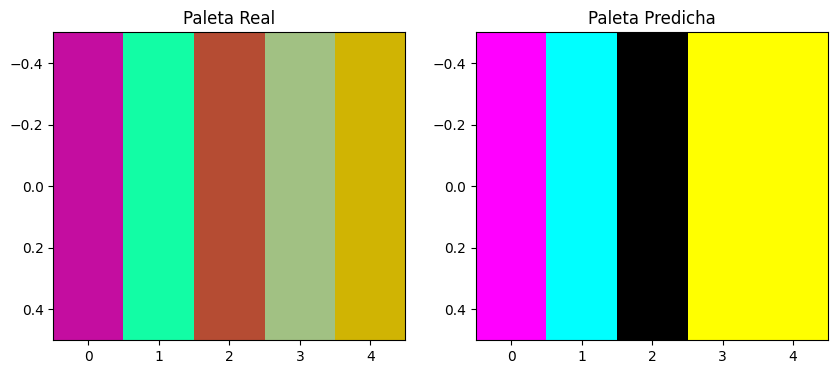

In [ ]:
import matplotlib.pyplot as plt

def plot_palettes(real, predicted, n_colors=5):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].imshow([real.cpu().numpy()], aspect='auto')
    ax[0].set_title("Paleta Real")
    ax[1].imshow([predicted.detach().cpu().numpy()], aspect='auto')
    ax[1].set_title("Paleta Predicha")
    plt.show()

# Ejemplo (después de una predicción):
real_palette = dummy_palettes[0]  # Shape: [5, 3]
predicted_palette = model(dummy_images[0].unsqueeze(0).to(device))[0]
plot_palettes(real_palette, predicted_palette)

salio mal debemos de cargar en pares con paletas

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WeightedMSELoss(nn.Module):
    def __init__(self, dominant_weight=2.0):
        super().__init__()
        self.dominant_weight = dominant_weight  # Peso extra para colores dominantes

    def forward(self, pred, target):
        # 1. Pérdida MSE base
        base_loss = F.mse_loss(pred, target)

        # 2. Calcular pesos basados en luminancia (colores más brillantes = más importantes)
        target_luminance = 0.2126 * target[..., 0] + 0.7152 * target[..., 1] + 0.0722 * target[..., 2]  # RGB -> Luminance
        weights = torch.softmax(target_luminance, dim=-1) * self.dominant_weight

        # 3. Pérdida ponderada
        weighted_loss = (weights.unsqueeze(-1) * (pred - target)**2).mean()  # [batch, n_colors, 1]

        return 0.5 * base_loss + 0.5 * weighted_loss  # Combinación balanceada

# ---------------------------------------------------------------
# Ejemplo de uso:
if __name__ == "__main__":
    # 1. Inicializar pérdida
    criterion = WeightedMSELoss(dominant_weight=3.0)

    # 2. Datos de ejemplo (batch_size=2, n_colors=5, RGB)
    pred_palettes = torch.rand(2, 5, 3)  # Predicciones del modelo
    real_palettes = torch.rand(2, 5, 3)  # Paletas reales

    # 3. Calcular pérdida
    loss = criterion(pred_palettes, real_palettes)
    print(f"Pérdida total: {loss.item():.4f}")

Pérdida total: 0.1883


In [10]:
import torch
import torch.nn.functional as F
from colorsys import rgb_to_hsv, hsv_to_rgb
import numpy as np

def rgb_to_hsv_torch(rgb):
    """Convierte tensor RGB [..., 3] a HSV (implementación manual para tensores)"""
    r, g, b = rgb[..., 0], rgb[..., 1], rgb[..., 2]
    maxc = torch.max(rgb, dim=-1)[0]
    minc = torch.min(rgb, dim=-1)[0]

    h = torch.zeros_like(maxc)
    mask = maxc != minc
    idx = (rgb[..., 0] == maxc) & mask
    h[idx] = (rgb[..., 1][idx] - rgb[..., 2][idx]) / (maxc[idx] - minc[idx])
    idx = (rgb[..., 1] == maxc) & mask
    h[idx] = 2.0 + (rgb[..., 2][idx] - rgb[..., 0][idx]) / (maxc[idx] - minc[idx])
    idx = (rgb[..., 2] == maxc) & mask
    h[idx] = 4.0 + (rgb[..., 0][idx] - rgb[..., 1][idx]) / (maxc[idx] - minc[idx])
    h = (h / 6.0) % 1.0

    s = torch.where(maxc > 0, (maxc - minc) / maxc, torch.zeros_like(maxc))
    v = maxc

    return torch.stack([h, s, v], dim=-1)

def hsv_to_rgb_torch(hsv):
    """Convierte tensor HSV [..., 3] a RGB (implementación manual)"""
    h, s, v = hsv[..., 0], hsv[..., 1], hsv[..., 2]
    i = torch.floor(h * 6.0)
    f = (h * 6.0) - i
    i = i.to(torch.int32) % 6

    p = v * (1.0 - s)
    q = v * (1.0 - f * s)
    t = v * (1.0 - (1.0 - f) * s)

    rgb = torch.zeros_like(hsv)
    rgb[..., 0] = torch.where(i == 0, v, torch.where(i == 1, q, torch.where(i == 2, p, torch.where(i == 3, p, torch.where(i == 4, t, v)))))
    rgb[..., 1] = torch.where(i == 0, t, torch.where(i == 1, v, torch.where(i == 2, v, torch.where(i == 3, q, torch.where(i == 4, p, p)))))
    rgb[..., 2] = torch.where(i == 0, p, torch.where(i == 1, p, torch.where(i == 2, t, torch.where(i == 3, v, torch.where(i == 4, v, q)))))

    return rgb

def adjust_palette(predicted, temperature=0.3, saturation_boost=1.2):
    """
    Args:
        temperature: <1 = más saturado, >1 = más pastel
        saturation_boost: Factor adicional de saturación (1.0 = neutral)
    """
    hsv = rgb_to_hsv_torch(predicted)

    # Ajuste combinado
    hsv[..., 1] = torch.clamp((hsv[..., 1] ** (1/temperature)) * saturation_boost, 0, 1)

    # Preservar colores ya saturados
    mask = hsv[..., 1] > 0.7
    hsv[..., 1][mask] = torch.min(hsv[..., 1][mask] * 1.1, torch.tensor(1.0))

    return hsv_to_rgb_torch(hsv)
# ---------------------------------------------------------------
# Ejemplo de uso:
if __name__ == "__main__":
    # 1. Generar predicciones dummy (ejemplo)
    raw_predictions = torch.rand(2, 5, 3)  # [batch=2, n_colors=5, RGB]

    # 2. Aplicar post-procesado
    adjusted = adjust_palette(raw_predictions, temperature=0.5)

    print("Predicciones originales (primer color del primer batch):")
    print(raw_predictions[0, 0])
    print("\nPredicciones ajustadas:")
    print(adjusted[0, 0])

Predicciones originales (primer color del primer batch):
tensor([0.7062, 0.4004, 0.3766])

Predicciones ajustadas:
tensor([0.7062, 0.5349, 0.5216])


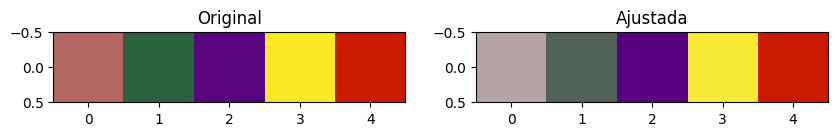

In [11]:
import matplotlib.pyplot as plt

def compare_palettes(original, adjusted):
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow([original.detach().cpu().numpy()])
    plt.title("Original")
    plt.subplot(122)
    plt.imshow([adjusted.detach().cpu().numpy()])
    plt.title("Ajustada")
    plt.show()

# Ejemplo de uso
compare_palettes(raw_predictions[0], adjust_palette(raw_predictions[0]))